In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive')

**Data Pre-Processing**

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np

input_dir = "Raw_Pan_Cards"
output_dir = "pre_processed_pan_cards"

def create_dirs(base_dir, sub_dirs):
    os.makedirs(base_dir, exist_ok=True)
    for sub_dir in sub_dirs:
        os.makedirs(os.path.join(base_dir, sub_dir), exist_ok=True)

def resize_and_normalize(image_path, img_size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (img_size, img_size))  # Resize to target size
    return img

def preprocess_images(input_dir, output_dir, img_size, train_split=0.7, val_split=0.15):
    all_images = [f for f in os.listdir(input_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    np.random.shuffle(all_images)

    n_train = int(train_split * len(all_images))
    n_val = int(val_split * len(all_images))
    train_images = all_images[:n_train]
    val_images = all_images[n_train:n_train + n_val]
    test_images = all_images[n_train + n_val:]

    subsets = {"train": train_images, "val": val_images, "test": test_images}
    create_dirs(output_dir, subsets.keys())

    for subset, images in subsets.items():
        for img_name in images:
            img_path = os.path.join(input_dir, img_name)
            preprocessed_img = resize_and_normalize(img_path, img_size)

            # Save image
            save_path = os.path.join(output_dir, subset, img_name)
            Image.fromarray(preprocessed_img).save(save_path)

    print("Preprocessing completed!")

img_size = 512
preprocess_images(
    input_dir=input_dir,
    output_dir=output_dir,
    img_size=img_size
)

Preprocessing completed!


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

train_dir = 'pre_processed_pan_cards/train'
val_dir = 'pre_processed_pan_cards/val'
test_dir = 'pre_processed_pan_cards/test'
img_size = 512

# Data Generators for loading and augmenting data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 92 images belonging to 1 classes.
Found 19 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


In [4]:
# Loading MobileNetV2 as base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freezing base model layers
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

<ipython-input-4-cad2d8444f31>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 49s 22s/step - accuracy: 0.7008 - loss: 0.4379 - val_accuracy: 1.0000 - val_loss: 9.6402e-05
Epoch 2/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 1.0000 - loss: 1.0909e-04

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 1.0000 - loss: 1.0909e-04 - val_accuracy: 1.0000 - val_loss: 5.9115e-06
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 12s/step - accuracy: 1.0000 - loss: 5.3806e-06 - val_accuracy: 1.0000 - val_loss: 1.1114e-07
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 1.0000 - loss: 1.0249e-06 - val_accuracy: 1.0000 - val_loss: 2.2103e-08
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 12s/step - accuracy: 1.0000 - loss: 1.3612e-07 - val_accuracy: 1.0000 - val_loss: 1.5066e-09
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 1.0000 - loss: 9.9981e-09 - val_accuracy: 1.0000 - val_loss: 4.7822e-10
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 11s/step - accuracy: 1.0000 - loss: 4.7024e-09 - val_accuracy: 1.0000 - val_loss: 6.5634e-11
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 1.0000 - loss: 2.4530e-09 - val_accuracy: 1.0000 - val_loss: 2.7762e-11
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 13s/step - accuracy: 1.0000 - loss: 8.1123e-

In [7]:
final_train_accuracy = history.history['accuracy'][-1] * 100
print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
final_test_accuracy = test_accuracy * 100
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Final Training Accuracy: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 9.7219e-12
Final Test Accuracy: 100.00%


In [ ]:
# Not Working as Confusion matrices are meant to show the performance of a classifier across multiple classes. When only one class exists it cannot build a proper confusion matrix
test_preds = model.predict(test_generator)
test_preds = (test_preds > 0.5).astype(int)
y_true = test_generator.classes
conf_matrix = confusion_matrix(y_true, test_preds)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[21]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [11]:
import pandas as pd
from sklearn.metrics import classification_report

# Predict on the test set
y_probs = model.predict(test_generator)  # Outputs probabilities
y_pred_labels = (y_probs > 0.5).astype(int).flatten()  # Convert probs to binary (0 or 1)

# True labels from the test generator
y_true = test_generator.classes

# Confidence scores
confidence_scores = y_probs.flatten()

results_df = pd.DataFrame({
    "True Label": y_true,
    "Predicted Label": y_pred_labels,
    "Confidence Score": confidence_scores
})

print("Prediction Results:")
print(results_df)
print("\n")
print("Classification Report:")
print(classification_report(y_true, y_pred_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction Results:
    True Label  Predicted Label  Confidence Score
0            0                0      5.512961e-11
1            0                0      1.326341e-13
2            0                0      8.188089e-14
3            0                0      2.876585e-12
4            0                0      2.578859e-12
5            0                0      7.813640e-13
6            0                0      4.435411e-15
7            0                0      9.421049e-15
8            0                0      6.887994e-13
9            0                0      6.034660e-12
10           0                0      7.502469e-11
11           0                0      3.177427e-13
12           0                0      5.759742e-11
13           0                0      1.199590e-12
14           0                0      4.934159e-14
15           0                0      1.745721e-13
16           0                0      6.890637e-13
17           0                0      4.36498

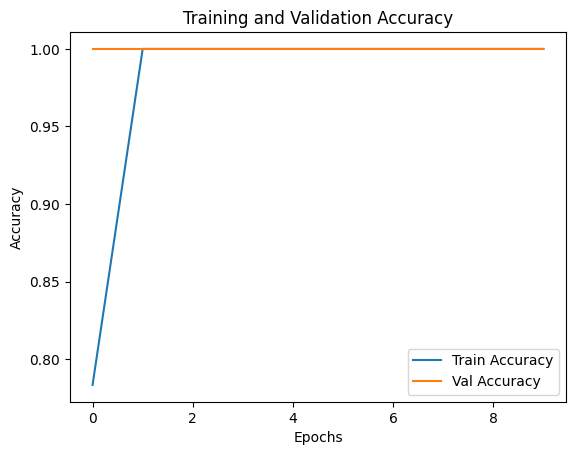

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()